In [2]:
from pathlib import Path
import gzip
import re

import numpy as np
import xarray as xr
import rioxarray
from pyproj import CRS, Transformer
from affine import Affine

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
import cartopy
cartopy.__version__

'0.22.0'

In [37]:
filepath = Path("/home/apbarret/src/rain_on_snow_database/data/test_data/ims1997036_00UTC_24km_v1.1.asc.gz")

## Define CRS and Grid Transform

The parameters for the CRS and grid definitions are taken from Table 5 of the [IMS Snow Cover User Guide](https://nsidc.org/sites/default/files/g02156-v001-userguide_1_1.pdf).

The projection parameters for the North Polar Stereographic projection contain a parameter "Longitude below the pole" with a value of 80W.  This is not a known projection parameter but I assume it is the Central Meridian.

The file header information state that the origin of the grid is the lower left corner.  However, the projected coordinates of the orgin in Table 5 suggest the origin is the upper left 

In [5]:
# Projection Parameters
projection_method = "stere"
central_latitude = 90.
central_longitude = -80.
true_scale_latitude = 60.
map_origin_latitude = 89.998344
map_origin_longitude = 55.000000
radius = 6371200.0

proj4_string = (f"+proj={projection_method} +lat_0={central_latitude} "
                f"+lat_ts={true_scale_latitude} +lon_0={central_longitude} "
                f"+ellps=sphere +R={radius}")
ims_crs = CRS.from_proj4(proj4_string)
latlon_crs = CRS.from_epsg(4326)

# Define pyproj transformer
geog_to_ims = Transformer.from_crs(latlon_crs, ims_crs, always_xy=True)

false_easting, false_northing = geog_to_ims.transform(map_origin_longitude, map_origin_latitude)

# Grid Parameters
nrow = 1024
ncol = 1024

# Calculated Grid parameters based on gpd
grid_cell_width = 23684.997  # meters
grid_cell_height = 23684.997  # meters
grid_map_origin_column = 511.5
grid_map_origin_row = 511.5
grid_origin_x = (grid_map_origin_column + 0.5) * grid_cell_width * -1.
grid_origin_y = (grid_map_origin_row + 0.5) * grid_cell_height * -1.

transform = Affine(grid_cell_width, 0.0, grid_origin_x,
                   0.0, grid_cell_height, grid_origin_y)

In [6]:
print("Projection Parameters")
print(f"     proj4 string: {proj4_string}")
print("")
print("Grid Parameters")
print(f"    grid_cell_width: {grid_cell_width}")
print(f"    grid_cell_width: {grid_cell_height}")
print(f"    grid_origin_x: {grid_origin_x}")
print(f"    grid_origin_y: {grid_origin_y}")
print(f"    false_easting: {false_easting}")
print(f"    false_northing: {false_northing}")

Projection Parameters
     proj4 string: +proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=-80.0 +ellps=sphere +R=6371200.0

Grid Parameters
    grid_cell_width: 23684.997
    grid_cell_width: 23684.997
    grid_origin_x: -12126718.464
    grid_origin_y: -12126718.464
    false_easting: 121.48747248972116
    false_northing: 121.48747248972113


Check projected coordinates of grid origin calculated in cell above against vaues given in Table 5 of the [IMS Snow Cover User Guide](https://nsidc.org/sites/default/files/g02156-v001-userguide_1_1.pdf).  Grid cell width and height is given to 3 decimal places but coordinates for the grid origin are given to nearest meter.

In [8]:
try:
    assert grid_origin_x == -12126597.0, f"Calculated x-coordinate of grid origin is {grid_origin_x}, value in User Guide is -12126597.0"
except Exception as err:
    print(err)

try:
    assert grid_origin_y == 12126840.0, f"Calculated y-coordinate of grid origin is {grid_origin_y}, value in User Guide is 12126597.0"
except Exception as err:
    print(err)

Calculated x-coordinate of grid origin is -12126718.464, value in User Guide is -12126597.0
Calculated y-coordinate of grid origin is -12126718.464, value in User Guide is 12126597.0


In [9]:
print(ims_crs)
print(transform)
print(false_easting, false_northing)

+proj=stere +lat_0=90.0 +lat_ts=60.0 +lon_0=-80.0 +ellps=sphere +R=6371200.0 +type=crs
| 23685.00, 0.00,-12126718.46|
| 0.00, 23685.00,-12126718.46|
| 0.00, 0.00, 1.00|
121.48747248972116 121.48747248972113


Define cartopy-style CRS

In [10]:
globe = ccrs.Globe(ellipse="sphere", semimajor_axis=6371200)
IMSNorthPolarStereo = ccrs.Stereographic(central_latitude=90., 
                                         central_longitude=-80.,
                                         true_scale_latitude=60.,
                                         globe=globe)

## Calculate Projected Coordinates

In [11]:
row = np.arange(0.5, nrow)
col = np.arange(0.5, ncol)
x, _ = transform * (col, 0.5)
_, y = transform * (0.5, row)

x += false_easting
y += false_northing

print(x)
print(y)

[-12114754.47802751 -12091069.48102751 -12067384.48402751 ...
  12067627.45897249  12091312.45597249  12114997.45297249]
[-12114754.47802751 -12091069.48102751 -12067384.48402751 ...
  12067627.45897249  12091312.45597249  12114997.45297249]


In [12]:
# [-12114754.47802751 -12091069.48102751 -12067384.48402751 ...
#   12067627.45897249  12091312.45597249  12114997.45297249]
# [ 12114997.45297249  12091312.45597249  12067627.45897249 ...
#  -12067384.48402751 -12091069.48102751 -12114754.47802751]

## Compare with Latitude and Longitude Grid

`x` and `y` are offset by ~12 km.  The distance between points is ~16 km.

In [13]:
def resolution_from_file(filepath):
    try:
        return re.search(r"_(\d+km)", filepath.name).groups()[0]
    except:
        raise ValueError("No resolution string found in {filepath.name}")

def read_ims_latlon(fp):
    grid_shapes = {
        "1km": (24576, 24576),
        "4km": (6144, 6144),
        "24km": (1024, 1024),
    }
    shape = grid_shapes[resolution_from_file(fp)]
    with gzip.open(fp, mode='rb') as f:
        grid = np.frombuffer(f.read(), dtype="<f4").reshape(shape)
    return grid
    
latitude_file = Path("imslat_24km.bin.gz")
longitude_file = Path("imslon_24km.bin.gz")

latitude = read_ims_latlon(latitude_file)
longitude = read_ims_latlon(longitude_file)

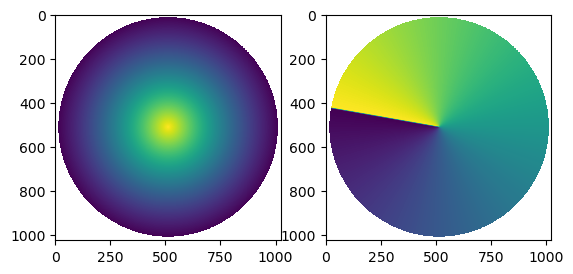

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(latitude)
ax[1].imshow(longitude)

In [15]:
nrow = 1024
ncol = 1024
ngrid = nrow * ncol

data = np.fromfile("imslat24km.test.1024x1024x2.double", dtype="float64")
new_lat = data[:ngrid].reshape(ncol, nrow)
new_lon = data[ngrid:].reshape(ncol, nrow)

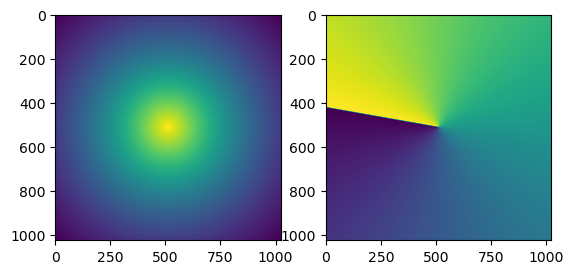

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(new_lat)
ax[1].imshow(new_lon)

Check range of lat and lon grids

In [17]:
print(f"Shape Original Latitude: {latitude.shape}")
print(f"Shape New Latitude: {new_lat.shape}")

print(f"Original Latitude: Min={np.nanmin(latitude)} Max={np.nanmax(latitude)}")
print(f"Original Longitude: Min={np.nanmin(longitude)} Max={np.nanmax(longitude)}")
print(f"New Latitude: Min={np.nanmin(new_lat)} Max={np.nanmax(new_lat)}")
print(f"New Longitude: Min={np.nanmin(new_lon)} Max={np.nanmax(new_lon)}")

Shape Original Latitude: (1024, 1024)
Shape New Latitude: (1024, 1024)
Original Latitude: Min=4.2836900320253335e-06 Max=89.99834442138672
Original Longitude: Min=-179.99989318847656 Max=179.99974060058594
New Latitude: Min=-20.48599632771306 Max=89.84023059095819
New Longitude: Min=-179.99970515907228 Max=179.99991617529722


In [18]:
try:
    assert np.isclose(latitude, new_lat.astype("float32"), equal_nan=False).all(), "Original latitude does not match recalculated latitude"
except Exception as err:
    print(err)

try:
    assert np.isclose(longitude, new_lon.astype("float32"), equal_nan=False).all(), "Original longitude does not match recalculated longitude"
except Exception as err:
    print(err)

Original latitude does not match recalculated latitude
Original longitude does not match recalculated longitude


The latitudes and longitudes in `imslat_24km.bin` and `imslon_24km.bin` are not the same as those in `imslat24km.test.1024x1024x2.double` that was created using the `gridloc` utility of `mapx` from the grid parameter definition file `Ims24km.gpd`.

How different are they?

In [19]:
dlat = latitude - new_lat
print(f"Latitude differences: Min={np.nanmin(dlat)}  Max={np.nanmax(dlat)}")

Latitude differences: Min=-0.16142810072381053  Max=0.16142582385603532


In [20]:
dlon = longitude - new_lon
print(f"Longitude differences: Min={np.nanmin(dlon)}  Max={np.nanmax(dlon)}")

Longitude differences: Min=-359.9337999665914  Max=26.505931352521458


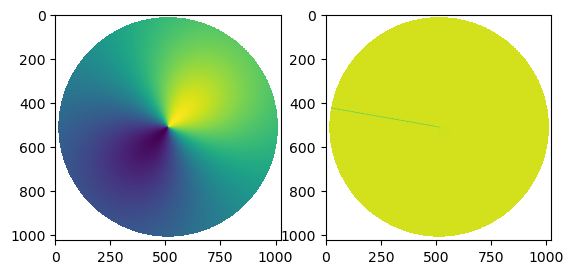

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(dlat)
ax[1].imshow(dlon)

Compare x and y coordinates

In [22]:
orig_x, orig_y = geog_to_ims.transform(longitude, latitude)
new_x, new_y = geog_to_ims.transform(new_lon, new_lat)

Check if they match

In [24]:
try:
    assert np.isclose(orig_x, new_x, atol=1e-4, equal_nan=False).all(), "Original x-coordinates do not match new coordinates"
except Exception as err:
    print(err)

try:
    assert np.isclose(orig_y, new_y, atol=1e-4, equal_nan=False).all(), "Original y-coordinates do not match new coordinates"
except Exception as err:
    print(err)

Original x-coordinates do not match new coordinates
Original y-coordinates do not match new coordinates


Differences between x and y are

In [25]:
diff_x = orig_x - new_x
print(f"Difference x: Min={np.nanmin(diff_x)} Max={np.nanmax(diff_x)}")
diff_y = orig_y - new_y
print(f"Difference y: Min={np.nanmin(diff_y)} Max={np.nanmax(diff_y)}")
offset = np.sqrt(diff_x**2 + diff_y**2)
print(f"Offset: Min={np.nanmin(offset)} Max={np.nanmax(offset)}")

Difference x: Min=-11844.124961921014 Max=-11840.935212113895
Difference y: Min=-11844.240223033354 Max=-11840.877694085706
Offset: Min=16745.927647364246 Max=16749.890116932318


Check if original x and y are constant for rows and columns for original columns

In [26]:
assert np.isclose(orig_x, orig_x[0], atol=1e-4).all()
assert np.isclose(orig_y.T, orig_y.T[0], atol=1e-4).all()

AssertionError: 

Check if x and y are constant for all rows and columns of new projected coordinates

In [27]:
assert np.isclose(new_x, new_x[0], atol=1e-4).all()
assert np.isclose(new_y.T, new_y.T[0], atol=1e-4).all()

For a grid, the projected coordinates on the x-axis should be the same for each row.  Likewise, projected coordinates for y should be the same for each column.

### Check that Calculated Grid Matches New Latitude and Longitude

In [28]:
x2d, y2d = np.meshgrid(x, y)  # create 2d mesh of calculated x and y

In [29]:
assert np.isclose(orig_x, x2d, atol=1e-4, equal_nan=False).all(), "Calculated x does not match x based on original latitudes"
assert np.isclose(orig_y, y2d, atol=1e-4, equal_nan=False).all(), "Calculated y does not match y based on original latitudes"

AssertionError: Calculated x does not match x based on original latitudes

In [30]:
assert np.isclose(new_x, x2d, atol=1e-4, equal_nan=False).all(), "Calculated x does not match x based on new latitudes"
assert np.isclose(new_y, np.flip(y2d, axis=0), atol=1e-4, equal_nan=False).all(), "Calculated y does not match y based on new latitudes"

In [31]:
diff_x = new_x - x2d
print(f"Difference between new x and calculate x: Min={np.nanmin(diff_x)} Max={np.nanmax(diff_x)}")
diff_y = new_y - np.flip(y2d, axis=0)
print(f"Difference between new y and calculate y: Min={np.nanmin(diff_y)} Max={np.nanmax(diff_y)}")


Difference between new x and calculate x: Min=-4.265348252374679e-08 Max=4.119647201150656e-08
Difference between new y and calculate y: Min=-4.264802555553615e-08 Max=4.1192834032699466e-08


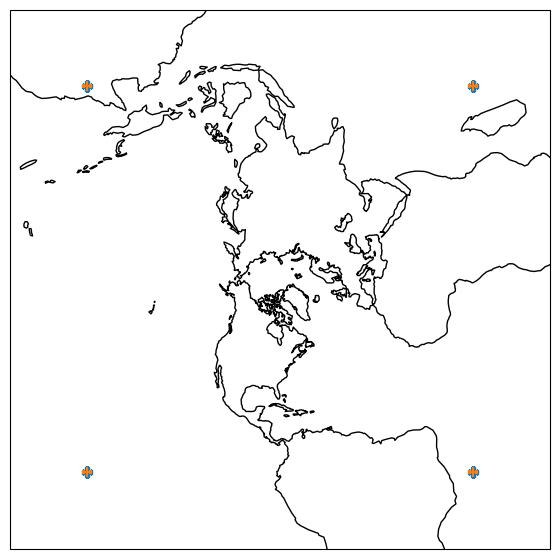

In [32]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
ax.set_extent([-180.,180.,-20.,90.], ccrs.PlateCarree())
ax.coastlines()

ax.scatter(new_x[[0,-1,-1,0],[0,0,-1,-1]], new_y[[0,-1,-1,0],[0,0,-1,-1]], s=50, marker="P")
ax.scatter(x2d[[0,-1,-1,0],[0,0,-1,-1]], y2d[[0,-1,-1,0],[0,0,-1,-1]], s=50, marker="+")

## Plot Grid Locations

#### Close Up of Pole

Text(0, 0.5, 'Northing (m)')

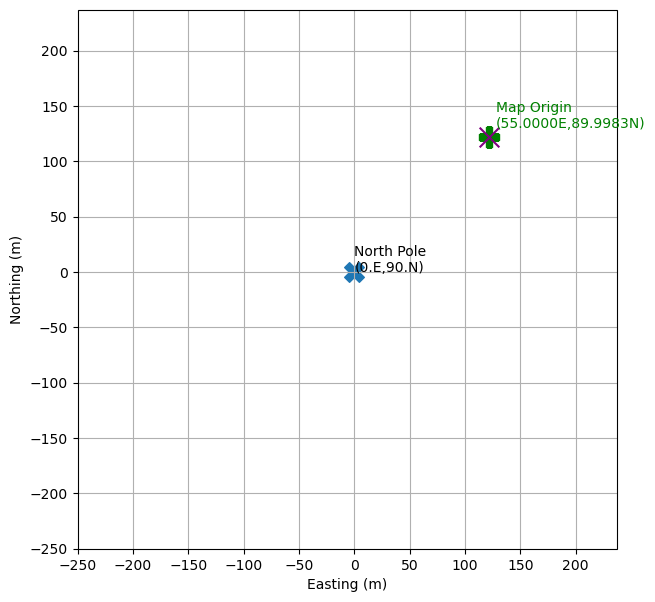

In [33]:
zoom = 0.01
extent = zoom * np.array([-1*grid_cell_width, grid_cell_width, -1*grid_cell_height, grid_cell_height])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
#ax.set_extent([-180.,180.,89.,90.], ccrs.PlateCarree())
ax.set_extent(extent, IMSNorthPolarStereo)
ax.coastlines()

# Plot North Pole
ax.scatter([0.0],[90.0], s=200, marker='X', transform=ccrs.PlateCarree())
ax.annotate("North Pole\n(0.E,90.N)", (0., 90.), transform=ccrs.PlateCarree())

# Add map grid origin in latitude and longitude
ax.scatter(map_origin_longitude, map_origin_latitude, s=200, marker='P', color="green", transform=ccrs.PlateCarree())
ax.annotate(f"Map Origin\n({map_origin_longitude:.4f}E,{map_origin_latitude:.4f}N)",
            (map_origin_longitude, map_origin_latitude), 
            xytext=(5,5), textcoords="offset points",
            transform=ccrs.PlateCarree(), 
            color='green', va="bottom", ha="left")

# Add estimates of False Easting and False Northing
# ... using estimated False Easting and False Northing in projected coordinates
ax.scatter(false_easting, false_northing, s=200, marker='x', color="purple", transform=IMSNorthPolarStereo)
# ... using CRS with FE and FN
#ax.scatter(0., 0., s=100, marker="*", color="pink", transform=IMSPolarStereoNorth_False)

xlocs = np.arange(-250.,250.,50.)
ylocs = np.arange(-250.,250.,50.)
ax.gridlines(xlocs=xlocs, 
             ylocs=ylocs,
             crs=IMSNorthPolarStereo,)
ax.set_xticks(xlocs)
ax.set_xlabel("Easting (m)")
ax.set_yticks(ylocs)
ax.set_ylabel("Northing (m)")


#### Plot Grid Mesh Near Pole

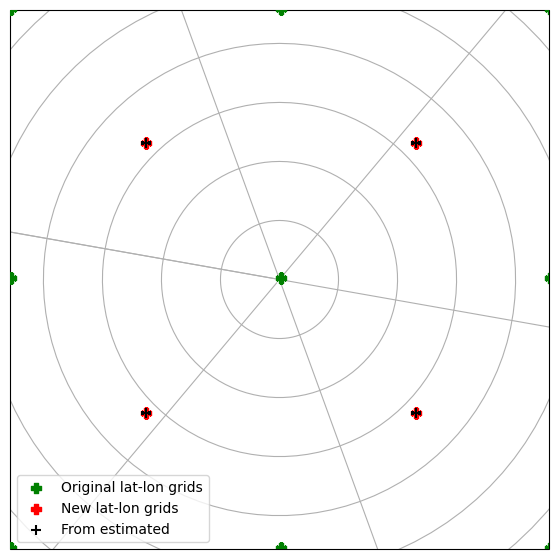

In [34]:

every = 1
zoom = 1.  #0.01
extent = zoom * np.array([-1*grid_cell_width, grid_cell_width, -1*grid_cell_height, grid_cell_height])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
#ax.set_extent([-180.,180.,89.,90.], ccrs.PlateCarree())
ax.set_extent(extent, IMSNorthPolarStereo)
ax.coastlines()
ax.gridlines()
# Add Pole
# ax.scatter([0.0],[90.0], s=200, marker='X', transform=ccrs.PlateCarree())

# Grid cell centers plotted from original lat and lon grids
ax.scatter(longitude[::every,::every], latitude[::every,::every], s=50, marker='P', color="green", 
           transform=ccrs.PlateCarree(), zorder=5, label="Original lat-lon grids")

# Grid cell centers plotted from lat and lon grids
ax.scatter(new_lon[::every,::every], new_lat[::every,::every], s=50, marker='P', color="red", 
           transform=ccrs.PlateCarree(), zorder=5, label="New lat-lon grids")

# Calculated grid cell centers using grid parameters
x2d, y2d = np.meshgrid(x, y)
ax.scatter(x2d, y2d, s=50, marker="+", color="k", transform=IMSNorthPolarStereo, zorder=6,
          label="From estimated")

# ax.scatter(longitude[509:514,510:515], latitude[509:514,510:515], s=10, marker='+', color="blue", 
#            transform=ccrs.PlateCarree(), zorder=5)

ax.legend(loc="lower left")

## Read data

Data are read as a byte string and decoded to ASCII.  The header information is saved.  The data values parsed into a `numpy.array`.

In [38]:
with gzip.open(filepath, 'r') as f:
    content = f.read().decode("ascii")
header = [line for line in content.split("\n") if (len(line) > 0) & (len(line) < nrow)]
data = np.array([list(line) for line in content.split("\n") if len(line) == nrow], dtype=float)

In [39]:
header

['Julian day of IMS data log: 97035',
 'Processing day            : Wed Oct 24 14:42:19 2001',
 'Total # scientific data sets: 1',
 'File description:',
 'This file contains Northern Hemisphere snow and ice coverage produced by the NOAA/NESDIS Interactive Multisensor Snow and Ice Mapping System (IMS) developed under the direction of the Interactive Processing Branch (IPB) of the Satellite Services Division (SSD). For more information, please contact Mr. Bruce Ramsay at bramsay@ssd.wwb.noaa.gov',
 'Map Label: Northern Hemisphere 1024x1024 snow and ice coverage',
 'Coordinate System: Polar Stereographic',
 'Data Values: 1 (sea), 2 (land), 3 (sea ice), 4 (snow),Data Values: 0 (outside Northern Hemisphere).',
 'Format: I1',
 'Dimensions: 1024 x 1024',
 '(1,1) starts at: lower left corner',
 '------------- Data set starts here: --------',
 ' Data Set #       1',
 '   Data Label:                          ',
 'Northern Hemisphere 1024x1024 Snow & Ice Chart',
 '   Coordinate System:           

In [40]:
data = np.where(data > 0, data, np.nan)
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

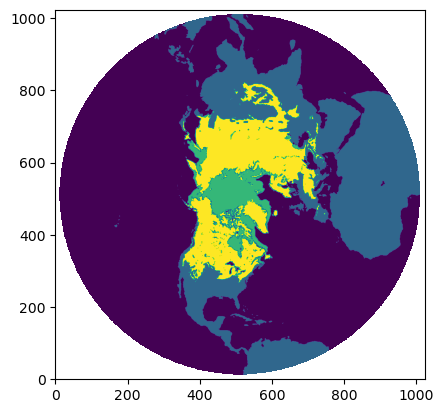

In [41]:
plt.imshow(data, origin="lower")

## Create an `xarray.Dataset`

In [42]:
encoding = {
    "surface_type": {
        "_FillValue": 0,
    },
}
ds = xr.Dataset({"surface_type": (['y', 'x'], data)}, coords={'x': x, 'y': y})
ds.encoding = encoding

In [43]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:       (y: 1024, x: 1024)
Coordinates:
  * x             (x) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
  * y             (y) float64 8kB -1.211e+07 -1.209e+07 ... 1.209e+07 1.211e+07
Data variables:
    surface_type  (y, x) float64 8MB nan nan nan nan nan ... nan nan nan nan nan

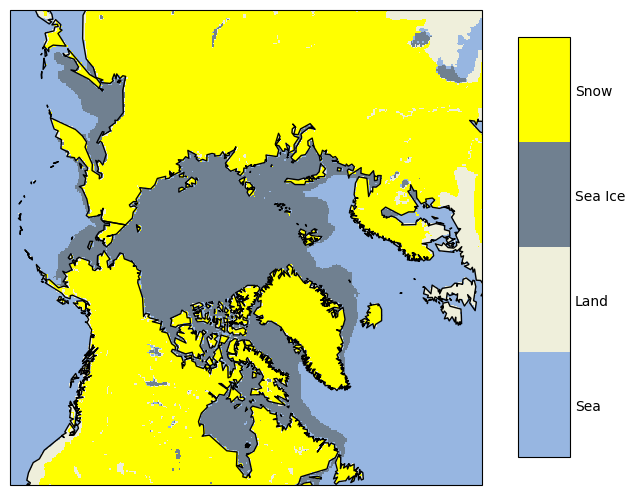

In [44]:
cmap = ListedColormap([cfeature.COLORS['water'], cfeature.COLORS['land'], 'slategrey', 'yellow'])
norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5, 4.5], ncolors=cmap.N, clip=True)

coastline = cfeature.GSHHSFeature()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
#ax.coastlines()
ax.add_feature(coastline)

img = ds.surface_type.plot.imshow(ax=ax, norm=norm, cmap=cmap, add_colorbar=False)

# Add colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.2, 0.075, 0.6])
cbar = fig.colorbar(
    img,
    cax=cax, orientation='vertical',
    extend='neither',
    spacing='proportional',
    label='',
    ticks=[1, 2, 3, 4],
    shrink=0.75,
)
cbar.ax.set_yticklabels(['Sea', 'Land', 'Sea Ice', 'Snow']);
cbar.ax.tick_params(which="both", length=0.)

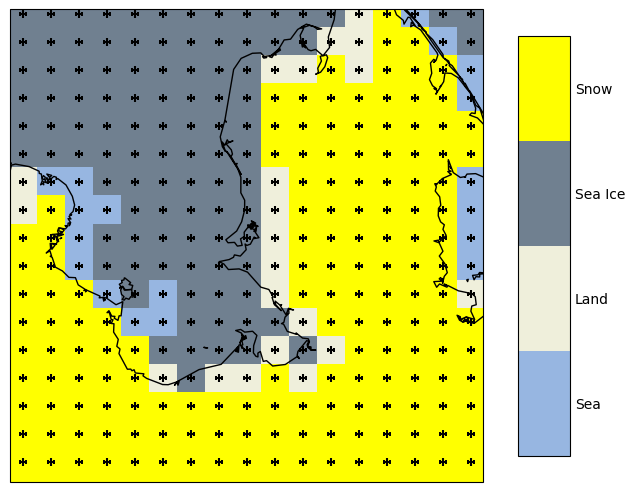

In [45]:
point = (-163.01706271914878, 64.54757445721512)
px, py = IMSNorthPolarStereo.transform_point(*point, ccrs.PlateCarree())
fov = 200000.
extent = [px-fov, px+fov, py-fov, py+fov]

cmap = ListedColormap([cfeature.COLORS['water'], cfeature.COLORS['land'], 'slategrey', 'yellow'])
norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5, 4.5], ncolors=cmap.N, clip=True)

coastline = cfeature.GSHHSFeature()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
ax.set_extent(extent, IMSNorthPolarStereo)
ax.add_feature(coastline)

img = ds.surface_type.plot.imshow(ax=ax, norm=norm, cmap=cmap, add_colorbar=False)

# Plot cell boundaries
gx2d, gy2d = np.meshgrid(ds.x, ds.y)
ax.scatter(gx2d, gy2d, marker='+', c='k')

# Add colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.2, 0.075, 0.6])
cbar = fig.colorbar(
    img,
    cax=cax, orientation='vertical',
    extend='neither',
    spacing='proportional',
    label='',
    ticks=[1, 2, 3, 4],
    shrink=0.75,
)
cbar.ax.set_yticklabels(['Sea', 'Land', 'Sea Ice', 'Snow']);
cbar.ax.tick_params(which="both", length=0.)

## Check Land Mask with Latitude and Longitude

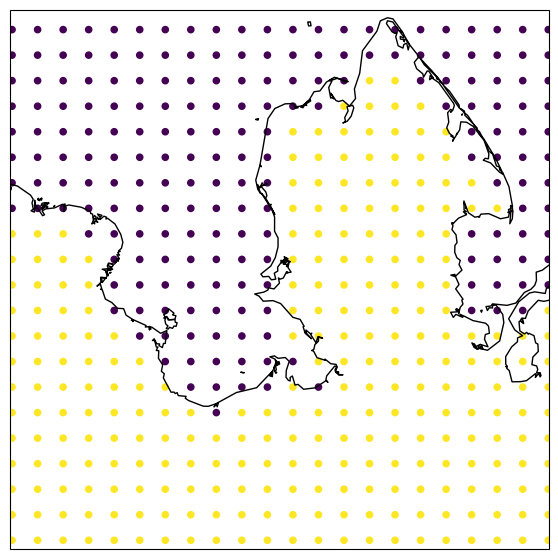

In [57]:
point = (-163.01706271914878, 64.54757445721512)
px, py = IMSNorthPolarStereo.transform_point(*point, ccrs.PlateCarree())
fov = 250000.
extent = [px-fov, px+fov, py-fov, py+fov]

# cmap = ListedColormap([cfeature.COLORS['water'], cfeature.COLORS['land'], 'slategrey', 'yellow'])
# norm = BoundaryNorm([0.5, 1.5, 2.5, 3.5, 4.5], ncolors=cmap.N, clip=True)

coastline = cfeature.GSHHSFeature()

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=IMSNorthPolarStereo)
ax.set_extent(extent, IMSNorthPolarStereo)
ax.add_feature(coastline)

land = np.flip(np.where((data == 2) | (data == 4), 1, 0), axis=0).flatten()
ax.scatter(longitude, latitude, s=20, marker='o', c=land, transform=ccrs.PlateCarree())

In [62]:
np.nanmin(new_lat)

-20.48599632771306

In [79]:
from shapely.geometry import MultiPolygon, MultiPoint, Point

In [66]:
multi_coast = MultiPolygon(coastline.geometries())

In [75]:
points = list(zip(new_lon.flatten(), new_lat.flatten()))

In [76]:
vpoints = MultiPoint(points)

In [81]:
is_land = [multi_coast.contains(Point(p)) for p in points]

KeyboardInterrupt: 

In [78]:
xx = is_land.reshape(data.shape)

False